In [50]:
import csv
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import json
import itertools
from sklearn.metrics import cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay
import os

In [32]:
def create_dataframe_from_jsonl(file_name, label_prefix):
    # Read the JSONL file line by line
    data = []
    with open(file_name, 'r') as file:
        for line in file:
            json_data = json.loads(line)
            #print(json_data)
            pmid = json_data['pmid']
            #accept = json_data['accept'][0]
            accept = json_data['accept'][0] if json_data['accept'] else "label missing"
            label_title = '{}_label'.format(label_prefix)
            data.append({'pmid': pmid, label_title: accept})

    # Create a DataFrame
    df = pd.DataFrame(data)
    
    return df


In [52]:
def visualize_label_frequencies(df, annotator_name, save_path='./prodigy/viz'):
    # Mapping labels to numerical values
    labels = ["Human-systematic-review", "Human-RCT-drug-intervention", "Human-RCT-non-drug-intervention", "Human-RCT-non-intervention", "Human-case-report", "Human-non-RCT-drug-intervention", "Human-non-RCT-non-drug-intervention", "Animal-systematic-review", "Animal-drug-intervention", "Animal-non-drug-intervention", "Animal-other", "Non-systematic-review", "Remaining"]

    label_to_numerical = {label: i for i, label in enumerate(labels)}

    # Create a new column with mapped values
    label_title = '{}_label'.format(annotator_name)

    # Plotting the frequency of each label with inverted y-axis and values on bars
    plt.figure(figsize=(10, 6))
    ax = df[label_title].value_counts().sort_values(ascending=True).plot(kind='barh', color='skyblue')
    plt.title(f'Label Frequency by Annotator {annotator_name}')
    plt.xlabel('Frequency')
    plt.ylabel('Label')

    # Display the frequency values on the bars
    for i, value in enumerate(df[label_title].value_counts().sort_values(ascending=True)):
        ax.text(value, i, str(value), va='center', ha='left')

    # Ensure the 'viz' folder exists
    os.makedirs(save_path, exist_ok=True)

    # Save the plot as an image
    save_filename = os.path.join(save_path, f'label_frequency_{annotator_name}.png')
    plt.savefig(save_filename, bbox_inches='tight')
    plt.show()

In [34]:
labels = ["label missing","Human-systematic-review", "Human-RCT-drug-intervention", "Human-RCT-non-drug-intervention", "Human-RCT-non-intervention", "Human-case-report", "Human-non-RCT-drug-intervention", "Human-non-RCT-non-drug-intervention", "Animal-systematic-review", "Animal-drug-intervention", "Animal-non-drug-intervention", "Animal-other", "Non-systematic-review", "Remaining"]

label_to_numerical = {label: i for i, label in enumerate(labels)}
print(label_to_numerical)

{'label missing': 0, 'Human-systematic-review': 1, 'Human-RCT-drug-intervention': 2, 'Human-RCT-non-drug-intervention': 3, 'Human-RCT-non-intervention': 4, 'Human-case-report': 5, 'Human-non-RCT-drug-intervention': 6, 'Human-non-RCT-non-drug-intervention': 7, 'Animal-systematic-review': 8, 'Animal-drug-intervention': 9, 'Animal-non-drug-intervention': 10, 'Animal-other': 11, 'Non-systematic-review': 12, 'Remaining': 13}


In [35]:
annotator1 = "shirin"
annotator2 = "ben"

### Load Annotator 1

In [36]:
file_name = './prodigy/annotated_output/pilot_500_pubmed_abstracts_shirin_test_review.jsonl'
result_df_1 = create_dataframe_from_jsonl(file_name, annotator1)
# label column names
label_title = '{}_label'.format(annotator1)
numeric_label_title = 'annotations_array_numeric_{}'.format(annotator1)
# Create a new column with mapped values
result_df_1[numeric_label_title] = result_df_1[label_title].map(label_to_numerical)

In [37]:
result_df_1

,pmid,shirin_label,annotations_array_numeric_shirin
0,37550718,Remaining,13
1,2500373,Remaining,13
2,36189588,Remaining,13
3,36314672,Remaining,13
4,29172241,Remaining,13
...,...,...,...
495,33034830,Remaining,13
496,35578869,Remaining,13
497,25825021,Human-non-RCT-drug-intervention,6
498,37495977,Remaining,13


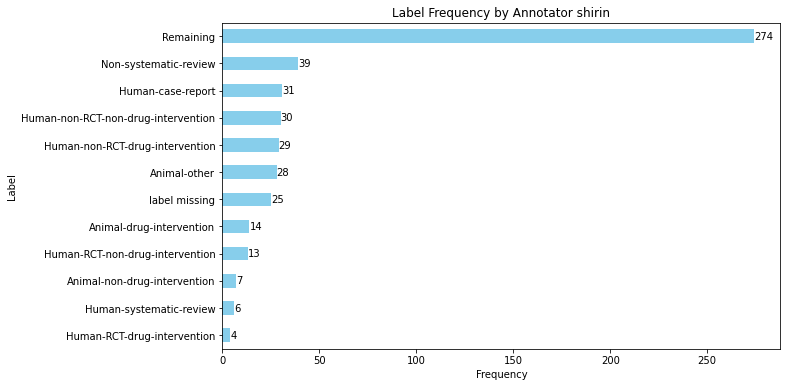

In [53]:
visualize_label_frequencies(result_df_1, annotator_name=annotator1)

### Load Annotator 2

In [39]:
file_name = './prodigy/annotated_output/pubmed_abstracts_pilot_ben.jsonl'
result_df_2 = create_dataframe_from_jsonl(file_name, annotator2)
# label column names
label_title = '{}_label'.format(annotator2)
numeric_label_title = 'annotations_array_numeric_{}'.format(annotator2)
# Create a new column with mapped values
result_df_2[numeric_label_title] = result_df_2[label_title].map(label_to_numerical)

In [40]:
result_df_2.head()

,pmid,ben_label,annotations_array_numeric_ben
0,37550718,Human-RCT-drug-intervention,2
1,2500373,Human-non-RCT-drug-intervention,6
2,36189588,Remaining,13
3,36314672,Remaining,13
4,29172241,Remaining,13


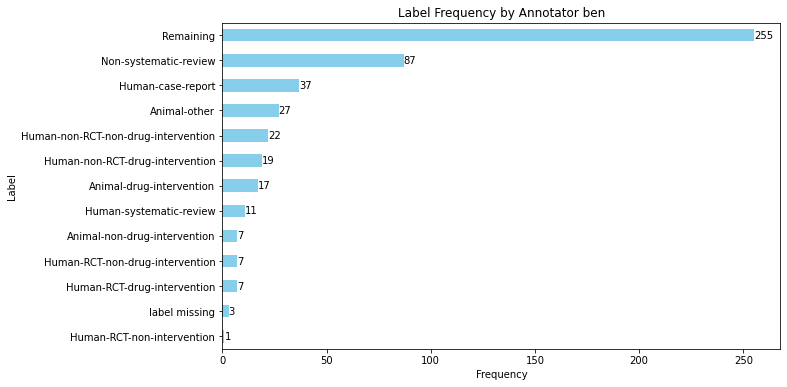

In [54]:
visualize_label_frequencies(result_df_2, annotator_name=annotator2)

### IAA Calculation

In [42]:
def calculate_cohen_kappa_from_cfm_with_ci(confusion, print_result=False):
    # COPIED FROM SKLEARN METRICS
    # Sample size
    n = np.sum(confusion)
    # Number of classes
    n_classes = confusion.shape[0]
    # Expected matrix
    sum0 = np.sum(confusion, axis=0)
    sum1 = np.sum(confusion, axis=1)
    expected = np.outer(sum0, sum1) / np.sum(sum0)

    # Calculate p_o (the observed proportionate agreement) and
    # p_e (the probability of random agreement)
    identity = np.identity(n_classes)
    p_o = np.sum((identity * confusion) / n)
    p_e = np.sum((identity * expected) / n)
    # Calculate Cohen's kappa
    kappa = (p_o - p_e) / (1 - p_e)
    # Confidence intervals
    se = np.sqrt((p_o * (1 - p_o)) / (n * (1 - p_e) ** 2))
    ci = 1.96 * se * 2
    ci_boundary_limits = 1.96 * se
    lower = kappa - ci_boundary_limits
    upper = kappa + ci_boundary_limits

    if print_result:
        print(
            f'p_o = {p_o}, p_e = {p_e}, lower={lower:.2f}, kappa = {kappa:.2f}, upper={upper:.2f}, boundary = {ci_boundary_limits:.3f}\n',
            f'standard error = {se:.3f}\n',
            f'lower confidence interval = {lower:.3f}\n',
            f'kappa score = {kappa:.3f}\n',
            f'upper confidence interval = {upper:.3f}', sep=''
        )

    return kappa, ci_boundary_limits

In [43]:
def calculate_overall_cohen_kappa_with_ci(df, annotators, single_annotatoins_case=False):
    # see implementation and explanation in https://rowannicholls.github.io/python/statistics/agreement/cohens_kappa.html

    for annotator1, annotator2 in itertools.combinations(annotators, 2):
        annotations1 = df[f'annotations_array_numeric_{annotator1}']  # ast.literal_eval(
        annotations2 = df[f'annotations_array_numeric_{annotator2}']
        
        if single_annotatoins_case:
            combined_array_1 = annotations1.values
            combined_array_2 = annotations2.values
        else:
            # Combine all rows into a single array
            combined_array_1 = np.concatenate([eval(row) for row in annotations1]).tolist()
            combined_array_2 = np.concatenate([eval(row) for row in annotations2]).tolist()

        confusion = confusion_matrix(combined_array_1, combined_array_2)
        print(f"Cohen-Kappa with Confidence intervals {annotator1} vs {annotator2}")
        calculate_cohen_kappa_from_cfm_with_ci(confusion, print_result=True)

In [44]:
annotators = [annotator1, annotator2]
annotators

['shirin', 'ben']

In [45]:
# Merge the two DataFrames on the 'pmid' column
result_df = pd.merge(result_df_1, result_df_2, on='pmid')

# Display the result DataFrame
result_df.shape

(500, 5)

In [46]:
result_df.head()

,pmid,shirin_label,annotations_array_numeric_shirin,ben_label,annotations_array_numeric_ben
0,37550718,Remaining,13,Human-RCT-drug-intervention,2
1,2500373,Remaining,13,Human-non-RCT-drug-intervention,6
2,36189588,Remaining,13,Remaining,13
3,36314672,Remaining,13,Remaining,13
4,29172241,Remaining,13,Remaining,13


In [168]:
calculate_overall_cohen_kappa_with_ci(result_df, annotators, single_annotatoins_case=True)

Cohen-Kappa with Confidence intervals demo1 vs demo2
p_o = 0.55, p_e = 0.1625, lower=0.20, kappa = 0.46, upper=0.72, boundary = 0.260
standard error = 0.133
lower confidence interval = 0.202
kappa score = 0.463
upper confidence interval = 0.723


In [47]:
calculate_overall_cohen_kappa_with_ci(result_df, annotators, single_annotatoins_case=True)

Cohen-Kappa with Confidence intervals shirin vs ben
p_o = 0.69, p_e = 0.307696, lower=0.49, kappa = 0.55, upper=0.61, boundary = 0.059
standard error = 0.030
lower confidence interval = 0.494
kappa score = 0.552
upper confidence interval = 0.611
